<a href="https://colab.research.google.com/github/vidhyaraj21/fm_radio_sdr/blob/main/finalyearproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#FISHER FACE FACE RECOGNITION

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import cv2
import time
import tensorflow as tf


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Now you can access the files in your Drive
# For example, if you have a dataset in your Drive:

train_path="/content/drive/MyDrive/train_images"
test_path="/content/drive/MyDrive/test_images"
height = 55
width = 55

# Load dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(height, width),
    color_mode="grayscale",  # Use grayscale if needed
    shuffle=False
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(height, width),
    color_mode="grayscale",  # Use grayscale if needed
    shuffle=False
)

Found 70 files belonging to 10 classes.
Found 30 files belonging to 10 classes.


Train Images:


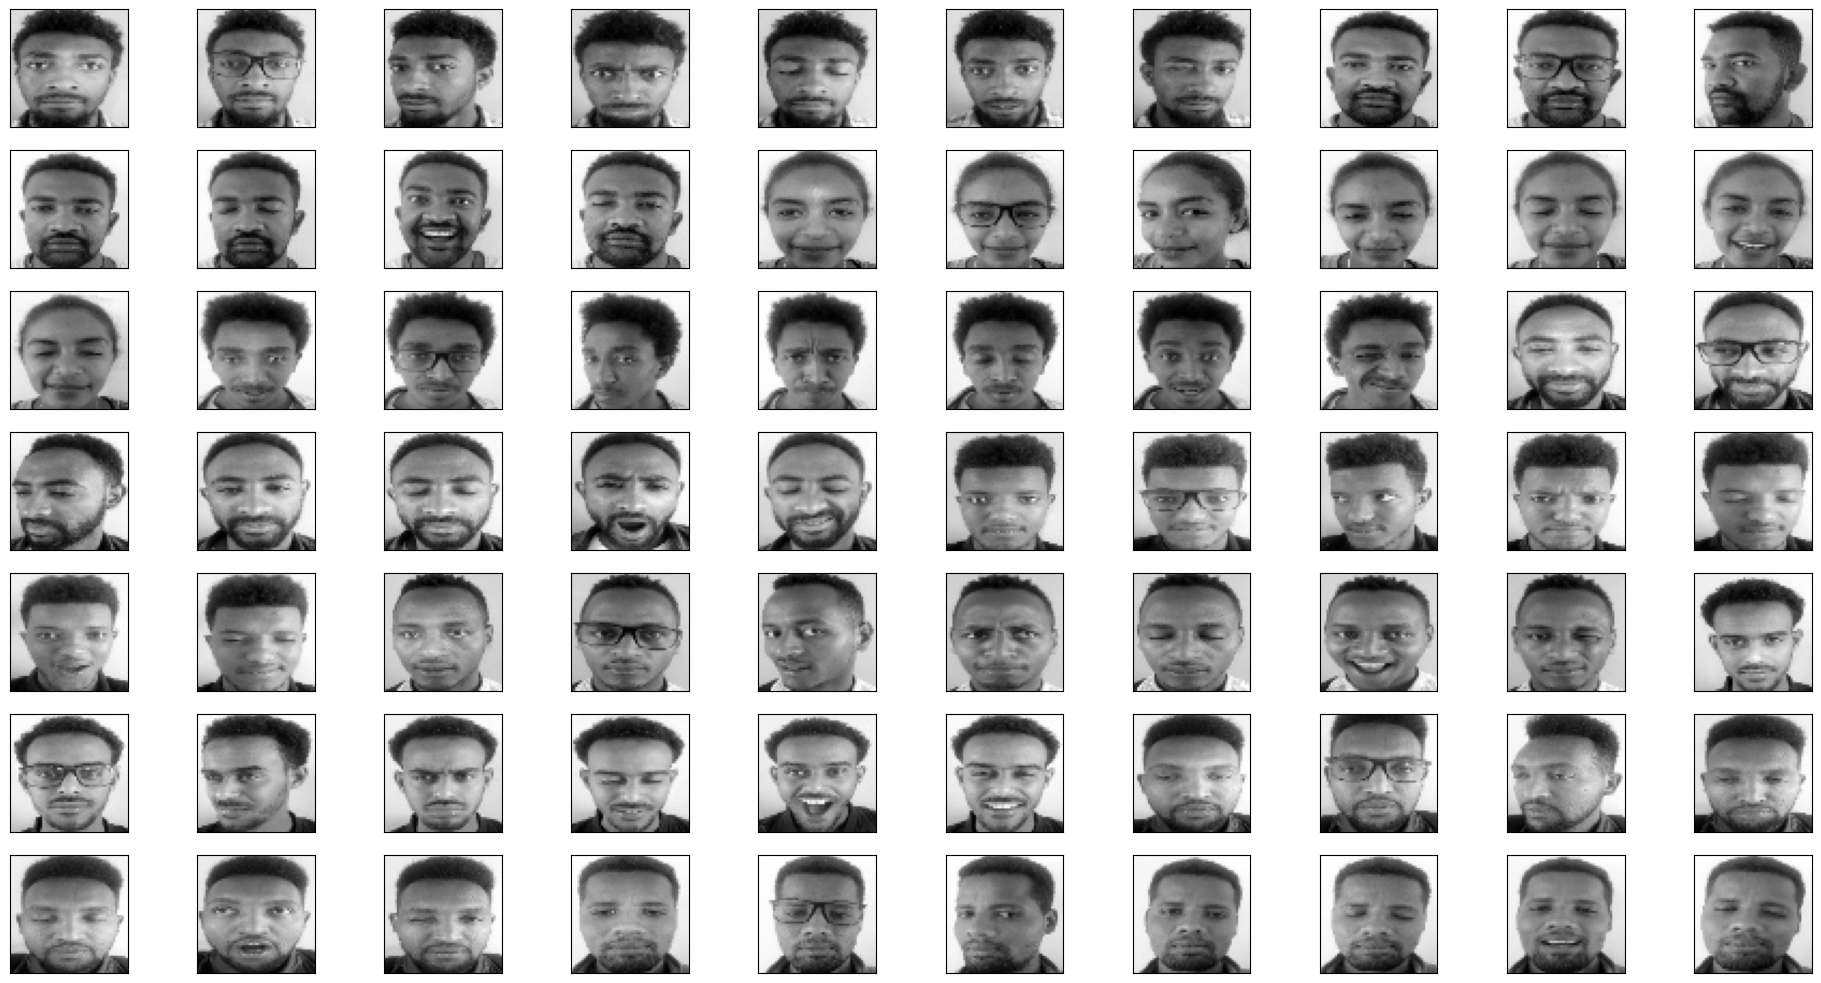

In [ ]:
# Initialize the tensor to store flattened images
training_tensor = np.ndarray(shape=(len(train_dataset.file_paths), height * width), dtype=np.float64)
lst = []

print('Train Images:')
for i, file_path in enumerate(train_dataset.file_paths):
    # Read and resize the image
    img = plt.imread(file_path)
    imresize = cv2.resize(img, (height, width))

    # Flatten and add to the tensor
    training_tensor[i, :] = np.array(imresize, dtype='float64').flatten()
    lst.append(imresize)

    # Plot the image
    plt.subplot(10, 10, 1 + i)
    plt.imshow(imresize, cmap='gray')
    plt.subplots_adjust(right=3.0, top=3)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False, top=False, right=False, left=False, which='both')

    # Break to avoid excessive plotting
    if i >= 99:  # Limit to 100 images for display
        break

plt.show()
images = np.array(lst)

Test Images:


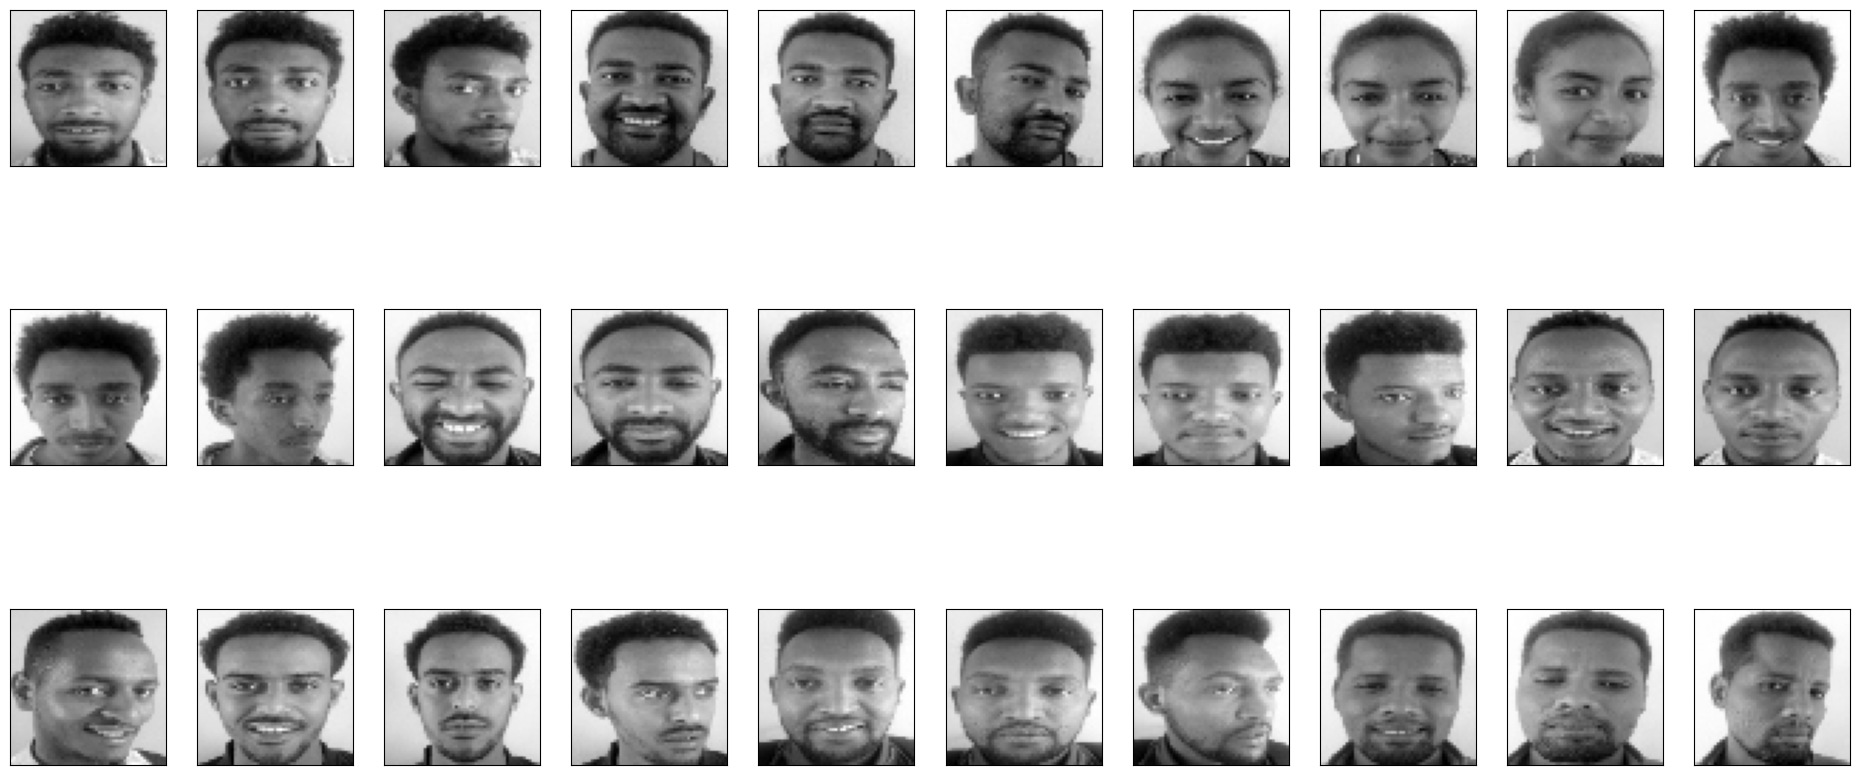

In [ ]:
testing_tensor = np.ndarray(shape=(len(test_dataset.file_paths), height * width), dtype=np.float64)
print('Test Images:')

for i, file_path in enumerate(test_dataset.file_paths):
    # Read and resize the image
    img = plt.imread(file_path)
    testresize = cv2.resize(img, (height, width))

    # Flatten and add to the tensor
    testing_tensor[i, :] = np.array(testresize, dtype='float64').flatten()

    # Plot the image
    plt.subplot(8, 10, 1 + i)
    plt.imshow(testresize, cmap='gray')
    plt.subplots_adjust(right=3.0, top=5)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False, top=False, right=False, left=False, which='both')

    # Break to avoid excessive plotting
    if i >= 79:  # Limit to 80 images for display
        break

plt.show()

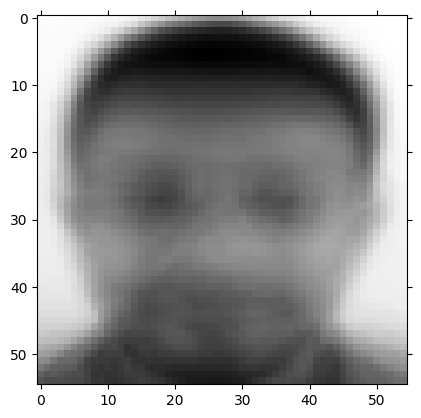

In [ ]:
mean_face = np.zeros((1,height*width))
for i in training_tensor:
    mean_face = np.add(mean_face,i)
mean_face = np.divide(mean_face,float(len(train_dataset))).flatten()
plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [ ]:
def pca_model():
    img_vectors = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))
    shortmean = np.mean(img_vectors, axis=0)
    normalized = img_vectors - shortmean
    covar = np.cov(np.transpose(normalized))
    eigvals, eigvects = np.linalg.eig(covar)
    mean_face = np.reshape(shortmean, (images.shape[1] * images.shape[2]))
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvects = eigvects[:, idx]
    eig_vectors = np.real(np.transpose(eigvects))
    imp_eig_vectors = eig_vectors[:60]  # taking only the first 60 eigenvectors
    eig_vectors_pca = eig_vectors[3:13]
    return [eigvals, eig_vectors, mean_face, imp_eig_vectors, img_vectors, eig_vectors_pca]

[eigvals, eig_vectors, mean_face, imp_eig_vectors, img_vectors, eig_vectors_pca] = pca_model()

In [ ]:
# Dictionary to store images for each of the 10 subjects (using integers for keys)
d = {i: [] for i in range(1, 11)}

# Loop through file paths once, parsing subject numbers directly
for file_path in train_dataset.file_paths:
    # Extract the subject number from the filename more robustly
    subject_num = int(os.path.basename(file_path)[4:6])  # Adjusted for integer keys

    if subject_num in d:
        d[subject_num].append(file_path)

In [ ]:
# Creating an X vector containing samples from each class
X = [d[key] for key in sorted(d.keys())]
tensor = []

print("Loading images for each class:")
for i in range(10):
    for j in range(min(7, len(X[i]))):  # Adjusted to avoid out-of-bounds errors
        img = plt.imread(X[i][j])
        imresize = cv2.resize(img, (height, width)).flatten()
        tensor.append(np.array(imresize, dtype='float64'))

# Organizing images per class
classes_data = []
for i in range(0, len(tensor), 7):
    classes_data.append(tensor[i:i + 7])

classes_data_np = np.array(classes_data)
print("Shape of classes_data_np:", classes_data_np.shape)

Loading images for each class:
Shape of classes_data_np: (10, 7, 3025)


In [ ]:
weights = []  # Corresponds to the weights of images in each class
for i in range(len(classes_data_np)):
    class_weights = []  # Weights per class
    for j in range(len(classes_data_np[i])):  # Use available images for each class
        image_weights = []  # A list of weights per image
        for k in range(len(imp_eig_vectors)):
            projected_weight = np.dot(imp_eig_vectors[k], classes_data_np[i][j].flatten())
            image_weights.append(projected_weight)
        class_weights.append(image_weights)
    weights.append(class_weights)
weights = np.array(weights)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# The mean weights for each class
def Fishers_model():
    mean_weights_class = np.mean(weights, axis=1)

    # Calculating Sb
    Sb = np.zeros((weights.shape[2], weights.shape[2]), dtype='float64')
    for i in range(0, len(mean_weights_class)):
        term1 = np.subtract(mean_weights_class[i].reshape((1, mean_weights_class[0].shape[0])),
                            weights.reshape((weights.shape[0] * weights.shape[1], weights.shape[2])).mean(axis=0)).reshape(1, weights.shape[2])
        term2 = np.transpose(term1)
        product = len(weights[i]) * np.matmul(term2, term1)
        Sb = Sb + product

    # Calculating Sw
    Sw = np.zeros((weights.shape[2], weights.shape[2]), dtype='float64')
    for i in range(0, len(weights)):
        for j in range(0, len(weights[i])):
            term1_sw = np.subtract(weights[i][j], mean_weights_class[i].reshape((1, mean_weights_class[0].shape[0]))).reshape(1, weights.shape[2])
            term2_sw = np.transpose(term1_sw)
            product_sw = np.matmul(term2_sw, term1_sw)
            Sw = Sw + product_sw

    # Sw inverse
    Sw_inverse = np.linalg.inv(Sw)

    # Compute Sw_inverse * Sb
    BinvA = np.matmul(Sw_inverse, Sb)

    # Eigenvalues and eigenvectors
    inv_eigval, inv_eigvec = np.linalg.eig(BinvA)

    # Sort by eigenvalues
    idx = inv_eigval.argsort()[::-1]
    inv_eigval = inv_eigval[idx]
    inv_eigvec = inv_eigvec[:, idx]

    # Transpose eigenvectors
    inv_eigvec = np.transpose(inv_eigvec)

    return [inv_eigval, inv_eigvec]

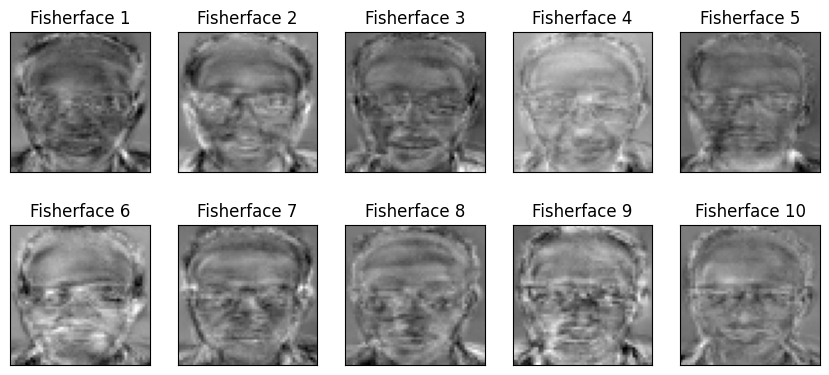

In [ ]:
[inv_eigval, inv_eigvec] = Fishers_model()

plt.figure(figsize=(12, 6))
for i in range(1, 11, 1):
    plt.subplot(2, 5, i)
    plt.imshow(np.reshape(np.real(np.matmul(inv_eigvec[i - 1], imp_eig_vectors)), (55, 55)), cmap='gray')
    plt.title('Fisherface {}'.format(i))
    plt.subplots_adjust(right=0.8, top=0.7)
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False, top=False, right=False, left=False, which='both')
plt.show()

# Keep top Fisherfaces
inv_eigvec = inv_eigvec[:10]

In [ ]:
# Reshaping weights for projection
all_imgs_w = np.reshape(weights, (-1, inv_eigvec.shape[-1]))
train_coeffs = []
for i in range(len(all_imgs_w)):
    t = []
    for j in range(len(inv_eigvec)):
        t.append(np.dot(inv_eigvec[j], all_imgs_w[i]))
    train_coeffs.append(t)
train_coeffs = np.array(train_coeffs)

In [ ]:
# Function to get coefficients for test images
def get_coefficients():
    test_imgs = testing_tensor
    test_pca_coeffs = []
    for i in range(len(test_imgs)):
        t = []
        for j in range(len(imp_eig_vectors)):
            t.append(np.dot(imp_eig_vectors[j], test_imgs[i]))
        test_pca_coeffs.append(t)
    test_pca_coeffs = np.array(test_pca_coeffs)

    lda_compute = test_pca_coeffs
    test_flda = []
    for i in range(len(lda_compute)):
        t = []
        for j in range(len(inv_eigvec)):
            t.append(np.dot(inv_eigvec[j], lda_compute[i]))
        test_flda.append(t)
    test_flda = np.array(test_flda)

    return [test_flda, test_imgs]

In [ ]:
# Get Fisherface coefficients for test images
[test_flda, test_imgs] = get_coefficients()

# Mahalanobis distance computation
predict = []
train_mean = np.mean(train_coeffs, axis=0)
train_cov = np.cov(train_coeffs, rowvar=False)
train_cov_inv = np.linalg.inv(train_cov)

for i in range(len(test_flda)):
    d = []
    for j in range(len(train_coeffs)):
        diff = test_flda[i] - train_coeffs[j]
        dist = np.sqrt(np.dot(np.dot(diff.T, train_cov_inv), diff))
        d.append(dist)
    d = np.array(d)
    predict.append(np.argmin(d))
print(predict)

[1, 0, 0, 7, 8, 66, 16, 16, 18, 21, 26, 26, 32, 32, 28, 37, 36, 38, 45, 44, 48, 55, 54, 55, 61, 59, 62, 66, 68, 69]


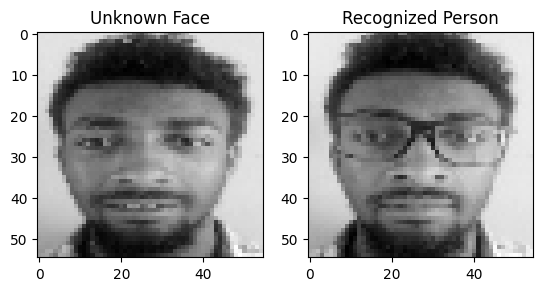

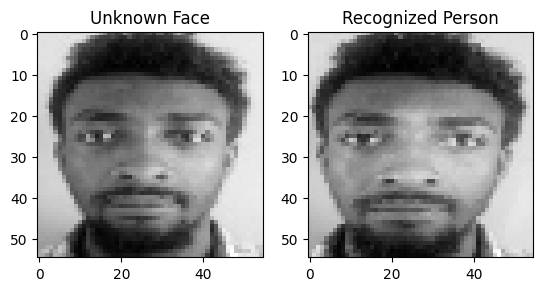

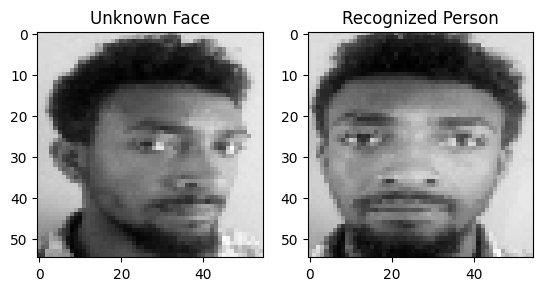

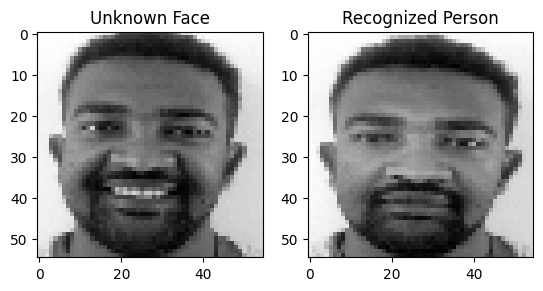

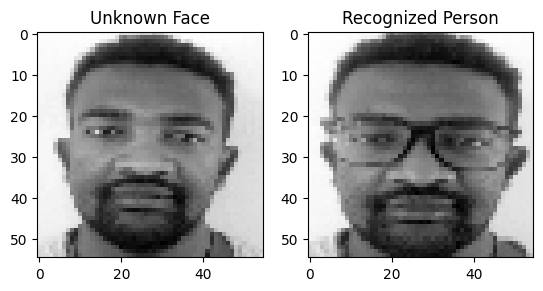

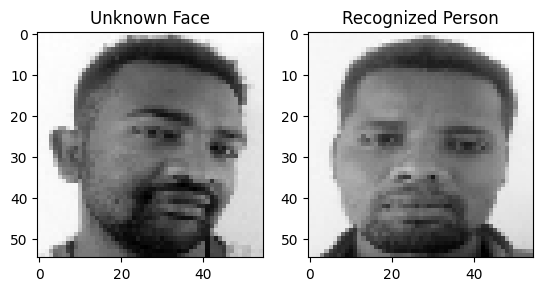

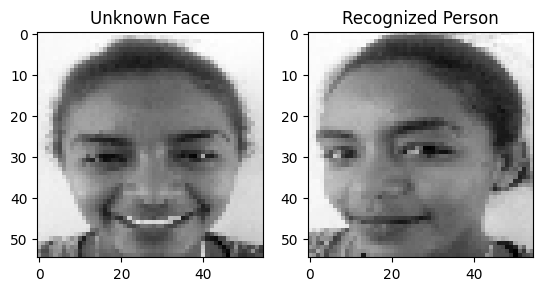

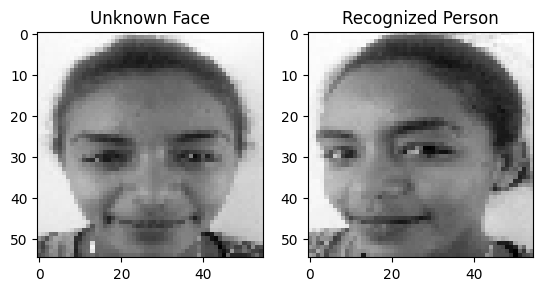

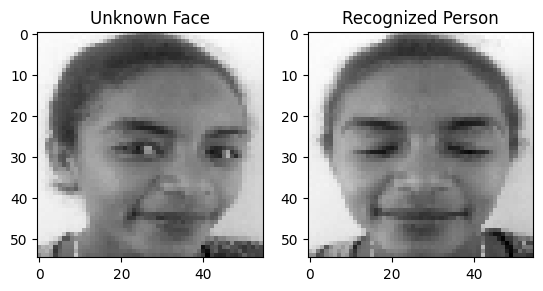

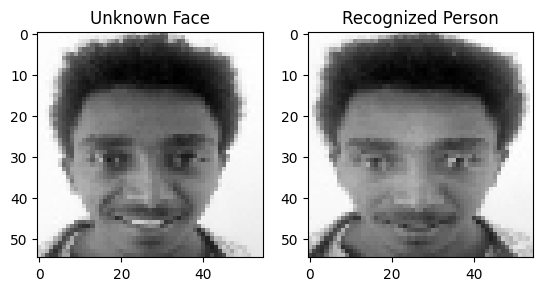

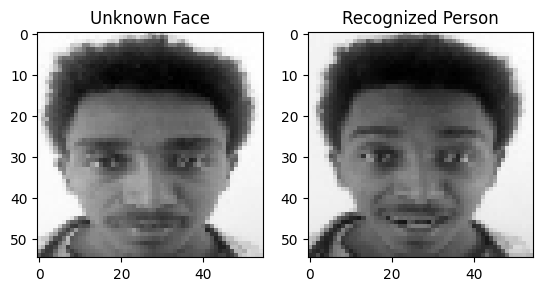

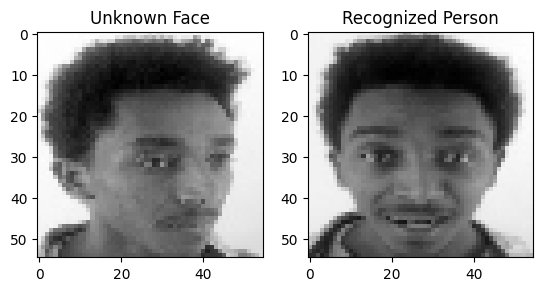

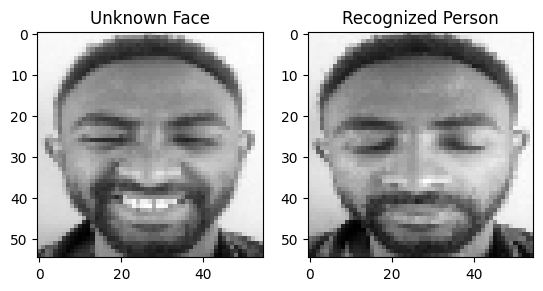

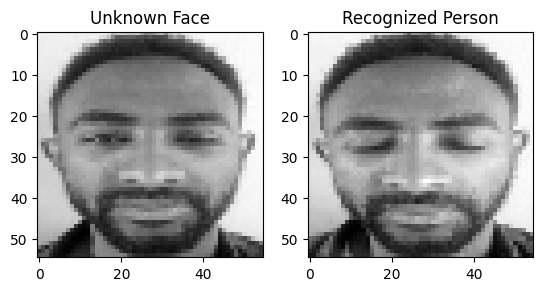

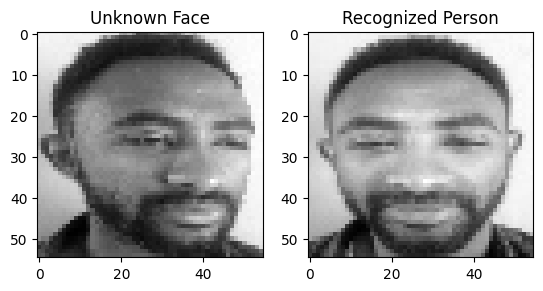

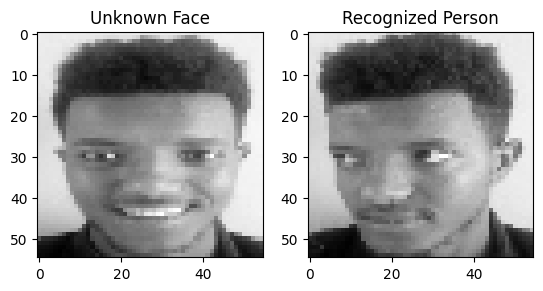

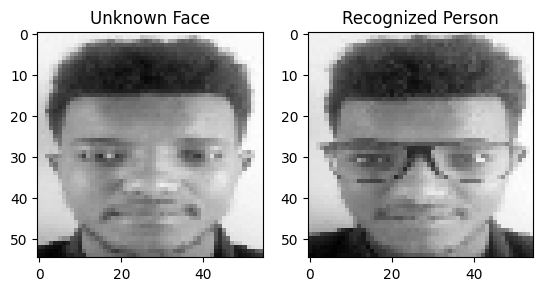

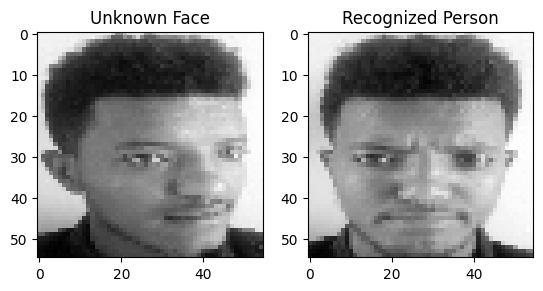

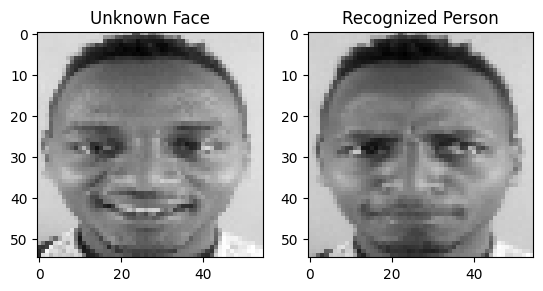

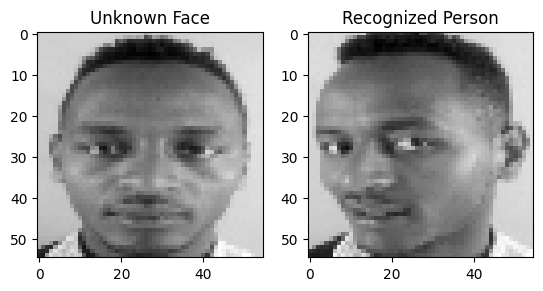

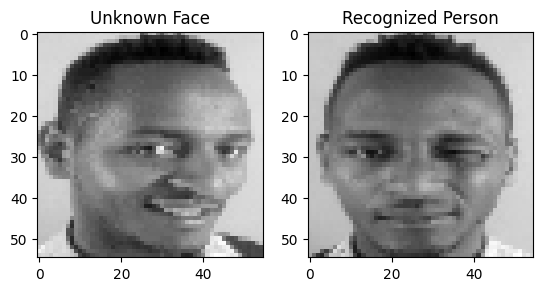

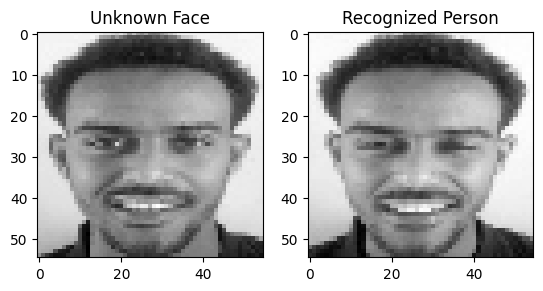

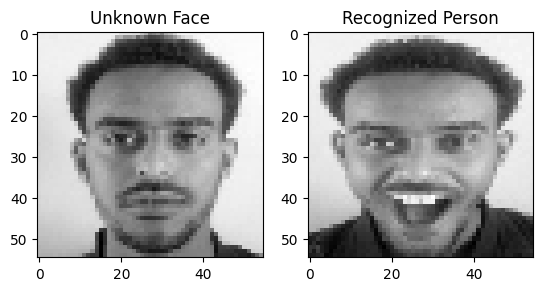

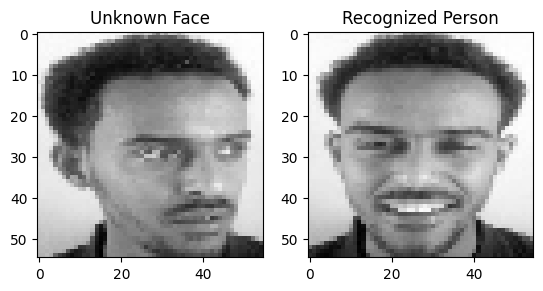

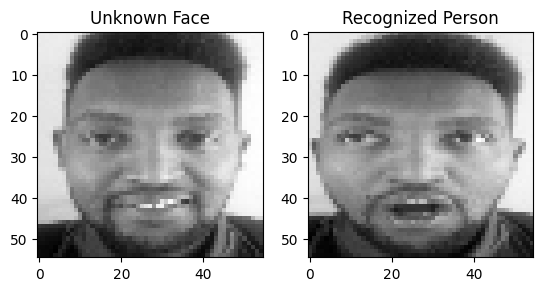

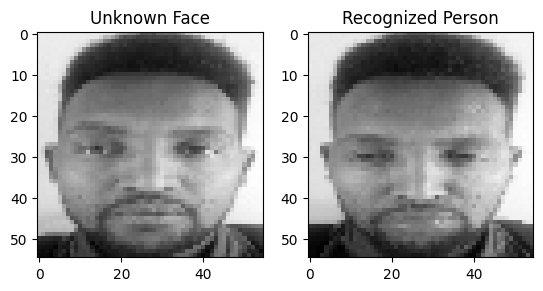

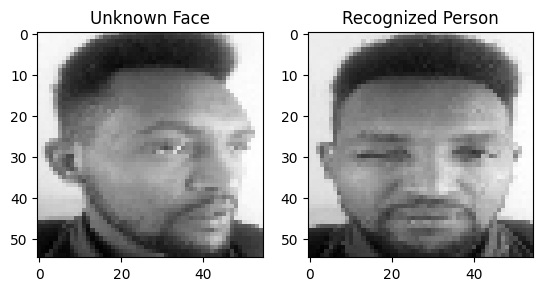

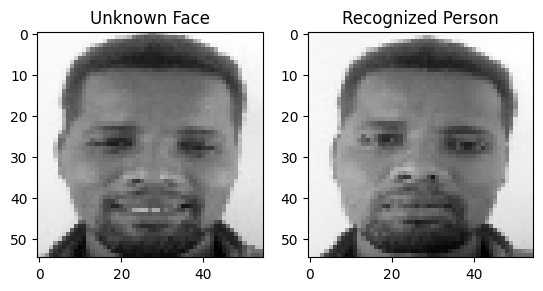

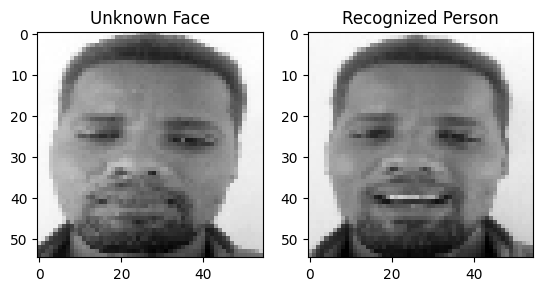

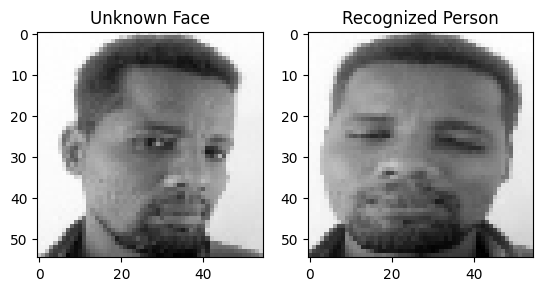

Accuracy: 96.67%


In [ ]:
correct_match = 0
total_length = 0

# Use file paths directly instead of dataset objects
train_image_paths = train_dataset.file_paths
test_image_paths = test_dataset.file_paths

for i in range(0, len(test_imgs)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_imgs[i].reshape((height, width)), cmap='gray')
    plt.title('Unknown Face')

    plt.subplot(1, 2, 2)
    plt.imshow(np.reshape(img_vectors[predict[i]], (height, width)), cmap='gray')
    plt.title('Recognized Person')
    plt.show()

    # Compare the file names (without extensions) to check for a match
    if os.path.basename(train_image_paths[predict[i]]).split(".")[0] == os.path.basename(test_image_paths[i]).split(".")[0]:
        correct_match += 1
    total_length += 1

accuracy = correct_match / total_length
print(f'Accuracy: {accuracy * 100:.2f}%')


In [ ]:
# Start the timer
t2_start = time.time()

# [Insert your code that performs the operation here]

# Print accuracy
print("The accuracy using 10 Fisherfaces is ", (correct_match / total_length) * 100)

# Stop the timer and calculate elapsed time
t2_stop = time.time()
print("\nElapsed Time During The Operation:", t2_stop - t2_start)

The accuracy using 10 Fisherfaces is  96.66666666666667

Elapsed Time During The Operation: 0.00021910667419433594
